# Proj 2: Fun with gradients

### Warm up: sharpen an image...?

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform as sktr

def get_points(im1, im2):
    print('Please select 2 points in each image for alignment.')
    plt.imshow(im1)
    p1, p2 = plt.ginput(2)
    plt.close()
    plt.imshow(im2)
    p3, p4 = plt.ginput(2)
    plt.close()
    return (p1, p2, p3, p4)

def recenter(im, r, c):
    R, C, _ = im.shape
    rpad = (int) (np.abs(2*r+1 - R))
    cpad = (int) (np.abs(2*c+1 - C))
    return np.pad(
        im, [(0 if r > (R-1)/2 else rpad, 0 if r < (R-1)/2 else rpad),
             (0 if c > (C-1)/2 else cpad, 0 if c < (C-1)/2 else cpad),
             (0, 0)], 'constant')

def find_centers(p1, p2):
    cx = np.round(np.mean([p1[0], p2[0]]))
    cy = np.round(np.mean([p1[1], p2[1]]))
    return cx, cy

def align_image_centers(im1, im2, pts):
    p1, p2, p3, p4 = pts
    h1, w1, b1 = im1.shape
    h2, w2, b2 = im2.shape
    
    cx1, cy1 = find_centers(p1, p2)
    cx2, cy2 = find_centers(p3, p4)

    im1 = recenter(im1, cy1, cx1)
    im2 = recenter(im2, cy2, cx2)
    return im1, im2

def rescale_images(im1, im2, pts):
    p1, p2, p3, p4 = pts
    len1 = np.sqrt((p2[1] - p1[1])**2 + (p2[0] - p1[0])**2)
    len2 = np.sqrt((p4[1] - p3[1])**2 + (p4[0] - p3[0])**2)
    dscale = len2/len1
    if dscale < 1:
        im1 = sktr.rescale(im1, dscale)
    else:
        im2 = sktr.rescale(im2, 1./dscale)
    return im1, im2

def rotate_im1(im1, im2, pts):
    p1, p2, p3, p4 = pts
    theta1 = math.atan2(-(p2[1] - p1[1]), (p2[0] - p1[0]))
    theta2 = math.atan2(-(p4[1] - p3[1]), (p4[0] - p3[0]))
    dtheta = theta2 - theta1
    im1 = sktr.rotate(im1, dtheta*180/np.pi)
    return im1, dtheta

def match_img_size(im1, im2):
    # Make images the same size
    h1, w1, c1 = im1.shape
    h2, w2, c2 = im2.shape
    if h1 < h2:
        im2 = im2[int(np.floor((h2-h1)/2.)) : -int(np.ceil((h2-h1)/2.)), :, :]
    elif h1 > h2:
        im1 = im1[int(np.floor((h1-h2)/2.)) : -int(np.ceil((h1-h2)/2.)), :, :]
    if w1 < w2:
        im2 = im2[:, int(np.floor((w2-w1)/2.)) : -int(np.ceil((w2-w1)/2.)), :]
    elif w1 > w2:
        im1 = im1[:, int(np.floor((w1-w2)/2.)) : -int(np.ceil((w1-w2)/2.)), :]
    assert im1.shape == im2.shape
    return im1, im2

def align_images(im1, im2):
    pts = get_points(im1, im2)
    im1, im2 = align_image_centers(im1, im2, pts)
    im1, im2 = rescale_images(im1, im2, pts)
    im1, angle = rotate_im1(im1, im2, pts)
    im1, im2 = match_img_size(im1, im2)
    return im1, im2

In [2]:
im1 = plt.imread('nutmeg.jpg')
im2 = plt.imread('DerekPicture.jpg')

In [3]:
import cv2
im3= cv2.flip(im1,-1)

/opt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


(264, 352, 3)


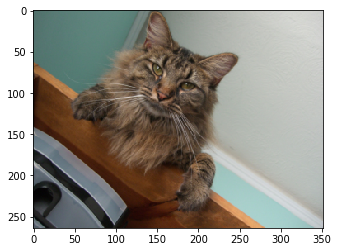

In [4]:
small_cat =sktr.rescale(im1, .25)
print(small_cat.shape)
plt.imshow(small_cat)

In [5]:
def gkern(l=5, sig=1.):
    """
    creates gaussian kernel with side length l and a sigma of sig
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)

In [6]:
def convolve(img, kernel):
    kernel = cv2.flip(kernel, -1)
    new_img = np.zeros(img.shape)
    for i in np.arange(kernel.shape[0]//2, img.shape[0] - kernel.shape[0]//2):
        for j in np.arange(kernel.shape[0]//2, img.shape[1] - kernel.shape[1]//2):
            for k in range(3): #for colors....?
                center = img[i - kernel.shape[0]//2 : i + kernel.shape[0]//2+1 , j - kernel.shape[1]//2 : j + kernel.shape[1]//2+1, k]
                new_img[i, j, k] = (center * kernel).sum() / 255
                
    final_img =(new_img/np.max(new_img))[int(kernel.shape[0]//2):-int(kernel.shape[0]//2), int(kernel.shape[1]//2):-int( kernel.shape[1]//2), :]
    return final_img, kernel.shape[0]//2, kernel.shape[0]//2

In [7]:
def low_pass(img, kernel):
    blur,v,h = convolve(img, kernel)
    reshaped_img = img[v:-v, h:-h, :]
    return np.clip(reshaped_img - blur, 0, 1)+.1

In [9]:
def vis_kernal(size, sd):
    hf = plt.figure()
    ha = hf.add_subplot(111, projection='3d')

    X, Y = numpy.meshgrid(np.arange(size), np.arange(size))  # `plot_surface` expects `x` and `y` data to be 2D
    ha.plot_surface(X, Y, gkern(size, sd)*100)

    plt.show()

In [10]:
plt.imshow(small_cat[5:-5,5:-5,:] - img[0]+.1)

NameError: name 'img' is not defined

In [11]:
high = small_cat[5:-5,5:-5,:] - img[0]
low = img[0]

NameError: name 'img' is not defined

In [12]:
vis_kernal(13,2.6)

ValueError: Unknown projection '3d'

<Figure size 432x288 with 0 Axes>

In [13]:
def auto_kernel(img):
    x = img.shape[0]
    size = int(x*.05)
    if size % 2 == 0:
        size += 1
    print(size)
    return gkern(size,int(size/5))

In [14]:
c,d = plt.imread('align_cat.jpg'), plt.imread('align_derek.jpg')
c,d = sktr.rescale(c, .25), sktr.rescale(d, .25)

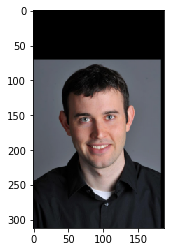

In [15]:
plt.imshow(c)

15


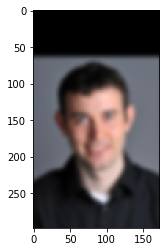

In [16]:
low = convolve(c, auto_kernel(c))[0]
plt.imshow(low)

In [18]:
der_img = np.array(np.gradient(c))[0,:,:,:]
plt.imshow(normalize(der_img))

NameError: name 'normalize' is not defined

In [19]:
import cv2
lap = np.array([[0 ,-1,0], [-1,4,-1], [0,-1,0]])
lap_img = convolve(c, lap)

In [20]:
def normalize(img):
    r,g,b = img[:,:,0], img[:,:,1], img[:,:,2]
    r,g,b = r-np.min(r), g-np.min(g), b-np.min(b)
    r,g,b = r/np.max(r), g/np.max(g), b/np.max(b)
    return np.dstack([r,g,b])

def normailze_black(img):
    r,g,b = img[:,:,0], img[:,:,1], img[:,:,2]
    r,g,b = r-np.mean(r), g-np.mean(g), b-np.mean(g)
    r,g,b = r-np.min(r), g-np.min(g), b-np.min(b)
    r,g,b = r-np.mean(r), g-np.mean(g), b-np.mean(g)
    r,g,b = r/np.max(r), g/np.max(g), b/np.max(b)
    return np.dstack([r,g,b])

15


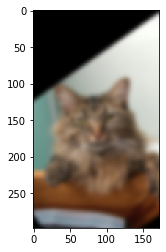

In [21]:
blur_cat = convolve(d, auto_kernel(d))
plt.imshow(blur_cat[0])

In [ ]:
#stack = normalize(np.add(blur_cat, der_img))

In [ ]:
try black and white